In [1]:
from openai import OpenAI
from matplotlib import patches
from matplotlib import pyplot as plt
import numpy as np
import PIL.Image

from agent_process import get_rough_crop
from agent_tools.img_outer_border import get_image_with_border, draw_grid_on_image
from agent_tools.hough_axis import detect_axis_bounding_box, detect_axis_bounding_box_contour

from prompts import PromptManager

from utilities.data_utils import image_to_data_url
from utilities.data_utils import image_path_to_image
from utilities.debug_tools import plot_image

from utilities.output_convert  import model_output_to_json

In [2]:
IMAGE_PATH = "test_figs/cz/fig6_5.png"
MODEL_NAME="/mnt/longcontext/models/siyuan/llama3/Qwen2.5-VL-72B-Instruct/"
client = OpenAI(api_key="token-abc123", base_url="http://127.0.0.1:8000/v1")

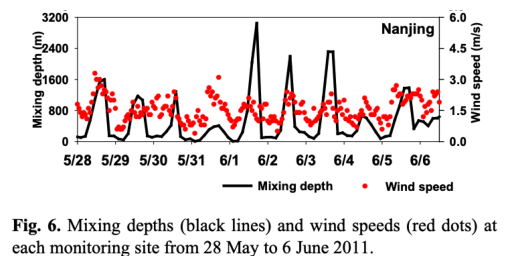

Image size: 741 x 368
Image mode: RGB
Image format: None
Image info: {'icc_profile': b'\x00\x00\x02\x08appl\x04\x00\x00\x00mntrRGB XYZ \x07\xe9\x00\x03\x00\x17\x00\x13\x000\x005acspAPPL\x00\x00\x00\x00APPL\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-appl\x13\x86\xa7\xc2Ay=*\xcdM)\x04X\xdd\x94=\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\ndesc\x00\x00\x00\xfc\x00\x00\x000cprt\x00\x00\x01,\x00\x00\x00Pwtpt\x00\x00\x01|\x00\x00\x00\x14rXYZ\x00\x00\x01\x90\x00\x00\x00\x14gXYZ\x00\x00\x01\xa4\x00\x00\x00\x14bXYZ\x00\x00\x01\xb8\x00\x00\x00\x14rTRC\x00\x00\x01\xcc\x00\x00\x00\x10chad\x00\x00\x01\xdc\x00\x00\x00,bTRC\x00\x00\x01\xcc\x00\x00\x00\x10gTRC\x00\x00\x01\xcc\x00\x00\x00\x10mluc\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x0cenUS\x00\x00\x00\x14\x00\x00\x00\x1c\x00Q\x002\x007\x00G\x002\x00G\x003\x00R\x004\x00Bmluc\x00\x00\x00\x00\x00\x00\x00\

In [3]:
image = image_path_to_image(IMAGE_PATH)
plot_image(image)

In [4]:
import cv2
def draw_grid_on_image(img, grid_size=50, color=(0, 0, 0), thickness=1)->np.ndarray:
    """
    Draw grid lines on an image using OpenCV.

    Parameters:
        img (numpy.ndarray): The input image (BGR format).
        grid_size (int): Distance between grid lines in pixels.
        color (tuple): Color of the grid lines (B, G, R).
        thickness (int): Line thickness.

    Returns:
        numpy.ndarray: Image with grid lines.
    """
    if isinstance(img, np.ndarray):
        pass
    elif isinstance(img, PIL.Image.Image):
        img = np.array(img)
    else:
        raise ValueError(f"draw_grid_on_image only accepts img type np.ndarray or PIL.Image.Image, got {type(img)} instead.")
    img_with_grid = img.copy()
    height, width = img.shape[:2]

    # Draw vertical lines
    for x in range(0, width, grid_size):
        cv2.line(img_with_grid, (x, 0), (x, height), color, thickness)

    # Draw horizontal lines
    for y in range(0, height, grid_size):
        cv2.line(img_with_grid, (0, y), (width, y), color, thickness)

    return img_with_grid

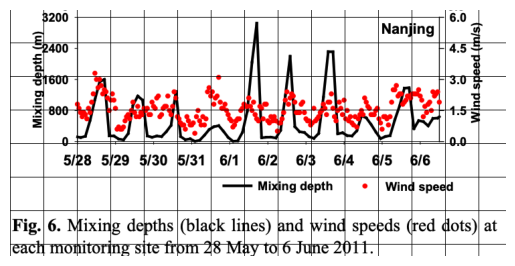

Image size: 741 x 368
Image mode: RGB
Image format: None
Image info: {}


In [5]:
plot_image(draw_grid_on_image((image)))

In [6]:
prompt_manager = PromptManager()
# prompt_manager.crop_prompt = """I will provide you with an image containing multiple charts. Your task is to identify and return the approximate bounding box coordinates (top-left and bottom-right corners) for the first chart within the image. tell me the height of the upper bound, the height of the lower bound first. Then output the bounding boxes. You are allowed to output boxes that are too big, but you can not output boxes that are too small that it didn't cover the full sub-chart. The format of the output should be a list of dictionaries, where each dictionary represents a chart and contains its coordinates in the following format:
# ```json
# [
#   {"chart_id": 1, "top_left": [x1, y1], "bottom_right": [x2, y2]}
# ]```
#  The bounding boxes can be slightly larger to ensure the entire chart is included.
#  """

In [7]:
box_message = get_rough_crop(client, image_to_data_url((image)), prompt_manager,MODEL_NAME)
print(box_message)

```json
[
  {
    "chart_id": 1,
    "top_left": [0, 0],
    "bottom_right": [643, 259]
  }
]
```


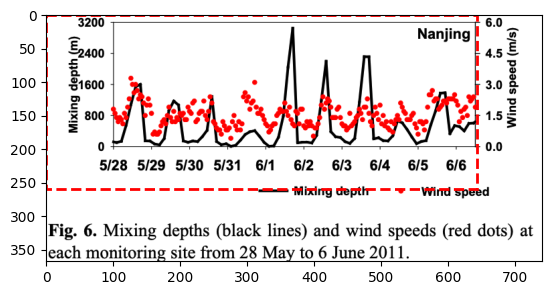

In [8]:


box_list = model_output_to_json(box_message)

fig, ax = plt.subplots()
# Display the image
img = image
ax.imshow(np.array(img))
# Create a Rectangle patch
for box in box_list:
    top_left = box["top_left"]
    bottom_right = box["bottom_right"]
    rect = patches.Rectangle(
        top_left,
        bottom_right[0] - top_left[0],
        bottom_right[1] - top_left[1],
        linewidth=2,
        edgecolor="r",
        facecolor="none",
        linestyle="--",
    )
    # draw rectangle with dashed line
    ax.add_patch(rect)
plt.show()

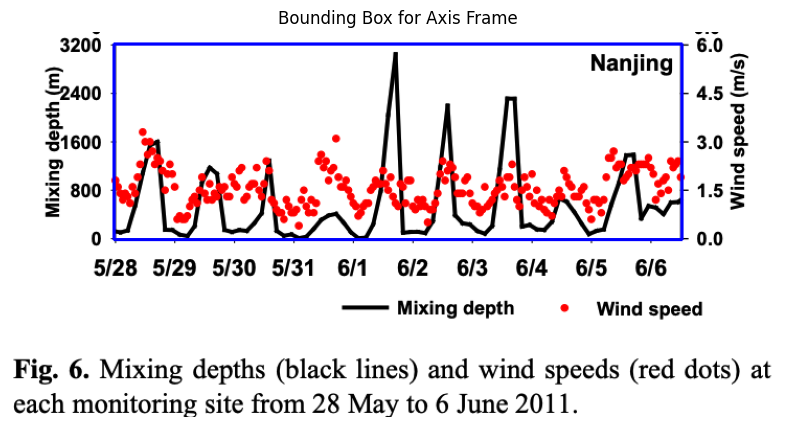

((99, 11), (642, 198))

In [9]:
detect_axis_bounding_box(image, debug=True)

In [ ]:
detect_axis_bounding_box_contour(image, debug=True)

((96, 12), (648, 198))